In [1]:
import pandas as pd
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
import plotly.express as px
from scipy import stats
%matplotlib inline

# Loading Data

In [2]:
label_df = pd.read_csv('')
q_df = pd.read_csv('')

In [3]:
symptom_cols = ['abdominal_pain', 'back_or_neck_pain', 'chest_pain',
                'chills', 'cold', 'confusion', 'cough', 'diarrhea', 'dizziness',
                'dyspnea', 'ear_pain', 'fast_heartbeat', 'feel_heat',
                'hand_muscles_pain', 'headache', 'healthy',
                'heat_over_37_5', 'hypertension', 'leg_pain', 'muscles_pain', 'other',
                'sore_throat', 'taste_smell', 'vomiting', 'weakness']
symp_cols_without_healthy = [x for x in symptom_cols if x not in ['healthy']]

In [4]:
label_df.columns

Index(['participant_num', 'result', 'check_datehour'], dtype='object')

# Creating dataframes for each period

In [5]:
# Difference between q date and check date
def combine_q_and_label(input_q,input_label):
    quest_df = input_q.copy()
    label_df_copy = input_label.copy()
    q_and_label_df = quest_df.merge(label_df_copy,how='inner',on='participant_num')
    q_and_label_df['quest_creation_timestamp'] = pd.to_datetime(q_and_label_df['quest_creation_timestamp'])
    q_and_label_df['check_datehour'] = pd.to_datetime(q_and_label_df['check_datehour'])
    q_and_label_df['days_delta'] = (q_and_label_df['quest_creation_timestamp']-q_and_label_df['check_datehour']).dt.days
    return q_and_label_df
    

In [6]:
def get_splitted_df(input_df,baseline_days_to_include,sick_period_days,sick=True):
    df = input_df.copy()
    df = df[df['days_delta'].between(-baseline_days_to_include-sick_period_days,sick_period_days)]
    if sick:
        sick_df = df[df['result']==1]
        label_period_df = sick_df[sick_df['days_delta'].between(-sick_period_days,sick_period_days)]
        baseline_df = sick_df[sick_df['days_delta'].between(-baseline_days_to_include,-sick_period_days-1)]
    else:
        healthy_df = df[df['result']==0]
        label_period_df = healthy_df[healthy_df['days_delta'].between(-sick_period_days,sick_period_days)]
        baseline_df = healthy_df[healthy_df['days_delta'].between(-baseline_days_to_include,-sick_period_days-1)]

    return {'label_period':label_period_df, 'baseline':baseline_df}

# Participant-wise relative risk

In [7]:
agg_dic = {'total_q':('participant_num','count')}
for col in symptom_cols:
    agg_dic[col] = (col,np.sum)

In [8]:
def get_symp_names(row,cols,ignore_index):
    """
    For each participant, create list of symptoms that appeared in desired period 
    row: row in dataframe
    cols: list of symptom names
    ignore_index: index of healthy column
    """
    i = 0
    symptoms = []
    for val in row:
        if val>0 and i!= ignore_index:
            symptoms.append(cols[i])
        i+=1
    return symptoms

In [9]:
def get_symp_occurance(input_df,include_symp_lst=False) -> pd.DataFrame:
    """
    Return Dataframe with symptoms occurrence count and list of symptoms that appeared at least once
    input_df: raw Dataframe of questionnaires
    include_symp_lst: boolean flag to include symptom lst in dataframe
    """
    # Perform aggregation per participant
    df = input_df.copy()
    grouped_df = df.groupby('participant_num').agg(**agg_dic).reset_index()
    # Dataframe with columns of symptoms only
    temp_symp_df = grouped_df[symptom_cols].copy()
    healthy_index = symptom_cols.index('healthy')
    # Get list of symptoms that appeared at least once
    if include_symp_lst:
        grouped_df['symptoms']= temp_symp_df.apply(lambda x: get_symp_names(x,symptom_cols,ignore_index=healthy_index),axis=1)
        grouped_df['num_symptoms'] = grouped_df['symptoms'].apply(lambda x: len(x))
    
    return grouped_df

In [10]:
def exclusive_func(row):
    """
    Return 1 only if no symptom was shown
    row: binary vector representing symptoms
    return: 1 if sum is 0, 0 otherwise.
    """
    if row.sum() ==0:
        return 1
    else:
        return 0

In [11]:
def get_percentile_score(x,col):
    return stats.percentileofscore(col,x)/100

In [12]:
def get_relative_risk_per_symp(label_period_df,baseline_df,method,full_output = False):
    lp_df = label_period_df.copy()
    base_df = baseline_df.copy()
    # get symptom occurence (num of symptoms appeared per participant)
    lp_grouped = get_symp_occurance(lp_df)
    base_grouped = get_symp_occurance(base_df)

    # count healthy only if it was exclusive in label period
    lp_grouped['exclusive_healthy'] = lp_grouped[symp_cols_without_healthy].apply(lambda x:exclusive_func(x),axis=1)
    lp_grouped.drop(columns=['healthy'],inplace=True)
    lp_grouped.rename(columns={'exclusive_healthy':'healthy'},inplace=True)
    
    #flatten baseline per participant
    if method == 'prop':
        for s in symptom_cols:
            if s == 'healthy':
                base_grouped[s] = base_grouped[s]/base_grouped['total_q']
            else:
                base_grouped[s] = base_grouped[s]/(base_grouped['total_q'] - base_grouped['healthy'])
    elif method == 'quantile':
        for s in symptom_cols:
            temp_col = base_grouped[s]
            base_grouped[s] = base_grouped[s].apply(lambda x: get_percentile_score(x,temp_col))
    #reset index to participant num - makes furhter analysis easier
    lp_grouped = lp_grouped.set_index('participant_num')[symptom_cols]
    base_grouped = base_grouped.set_index('participant_num')[symptom_cols]

    # binary occurence for label period
    lp_grouped.where(lp_grouped==0,1,inplace=True)
    
    #calculate relative risk
    rr_df  = lp_grouped.sub(base_grouped)
    symp_rr = rr_df.mean().sort_values()
    if full_output:
        return {'relative_risk':symp_rr,
                'label_period':lp_grouped,
                'baseline':base_grouped}
    else:
        return symp_rr

# Comparing healthy and sick relative risk per symptom

In [13]:
combined_df = combine_q_and_label(q_df,label_df)

In [14]:
def get_symp_rr_diff(input_df,baseline_days_to_include,sick_period_days,method):
    """

    input_df: raw pd.DataFrame of questionnaires data
    baseline_days_to_include: how many days should be included in baseline defenition
    sick_period_days: sick period window length
    method: 'prop' for proportion of q's with any symptoms or quantile for percentile score
    return: pd.Series of relative risk score for each symptom
    """
    df = input_df.copy()
    # get dataframes for label and baseline periods, splitted by positive or negative label
    sick_dic = get_splitted_df(df,baseline_days_to_include,sick_period_days,True)
    healthy_dic = get_splitted_df(df,baseline_days_to_include,sick_period_days,False)


    # get symptom relative risk for sick and healthy participants
    sick_symp_rr = get_relative_risk_per_symp(sick_dic['label_period'],sick_dic['baseline'],method)
    healthy_symp_rr = get_relative_risk_per_symp(healthy_dic['label_period'],healthy_dic['baseline'], method)
    
    diff = sick_symp_rr/healthy_symp_rr
    return diff.sort_values()

# Find most common symptoms

In [15]:
def get_most_common_symptoms(input_df,baseline_days_to_include,sick_period_days,n_symptoms):
    res = get_splitted_df(combined_df,baseline_days_to_include,sick_period_days)
    label_p_df = res['label_period']
    base_df = res['baseline']
    label_symp_count = label_p_df[symptom_cols].sum()
    base_symp_count = base_df[symptom_cols].sum()
    symp_count = label_symp_count + base_symp_count
    symp_count = symp_count.sort_values(ascending=False)
    top_symps = symp_count[:n_symptoms].index
    return top_symps

# Tests

In [16]:
sick_period_days = 4
baseline_days_to_include = 60

In [17]:
top_symps = get_most_common_symptoms(combined_df,baseline_days_to_include,sick_period_days,10)

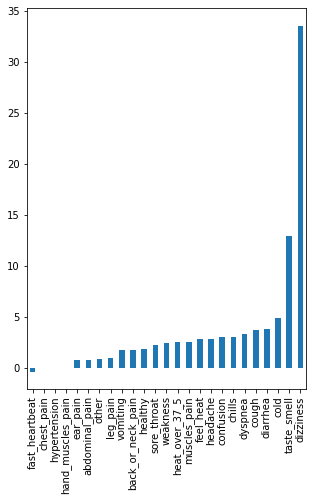

In [18]:
a = get_symp_rr_diff(combined_df,baseline_days_to_include,sick_period_days,'prop')
ax = a.plot(kind='bar',figsize=(5,7))
# a.to_csv('data/prop.csv')

In [19]:
def calc_rr_score_sum(row,rr):
    score = 0
    for symp in rr.index:
        score += rr[symp] * row[symp]
    return score

In [20]:
def calc_rr_score_max(row,rr):
    max_score = 0
    for symp in rr.index:
        new_score = rr[symp] * row[symp]
        if new_score>max_score:
            max_score = new_score
    return max_score

In [40]:
rr = a[top_symps]
q_test = combine_q_and_label(q_df,label_df)
q_test = q_test.merge(label_df[['participant_num','result']])
q_test['rr_score_sum'] = q_test.apply(lambda x: calc_rr_score_sum(x,rr),axis=1)
q_test['rr_score_max'] = q_test.apply(lambda x: calc_rr_score_max(x,rr),axis=1)

In [42]:
def get_window(day_delta, window_size):
    if day_delta < 0:
        day_delta -= window_size

    window = int(day_delta / (window_size + 1))
    return window


def get_symptom_proportions_and_windows(input_df, window_size):
    df = input_df.copy()
    # Split to windows according to set period of days - window size
    df['window'] = df['days_delta'].apply(lambda x: get_window(x, window_size))
    # aggregate_over_window
    grouped_df = df.groupby('window').agg(**agg_dic).reset_index()
    norm_grouped_df = grouped_df.copy()
    #Normalize by dividing sum of symptoms declared by sum of total questionnaires
    for col in symptom_cols:
        norm_grouped_df[col] = norm_grouped_df[col] / norm_grouped_df['total_q']

    return norm_grouped_df, grouped_df

In [68]:
df = q_test.copy()
df['window'] = df['days_delta'].apply(lambda x: get_window(x, 1))
g_df = df[['rr_score_sum','rr_score_max','window','result']].groupby(['window','result']).agg(np.mean).reset_index()

In [70]:
pos = g_df[g_df.result==1].set_index('window')
neg = g_df[g_df.result==0].set_index('window')
pos_vs_neg = pos/neg
pos_vs_neg = pos_vs_neg[['rr_score_sum','rr_score_max']]

In [71]:
fig = px.line(pos_vs_neg)
fig.update_layout(
    width=1000,
    height = 500
)
fig.show()

In [54]:
fig = px.line(g_df,
              x='window',
              y='rr_score_sum',
              color='result')
fig.update_layout(
    width=1000,
    height = 500,
    yaxis_range = [0,10]
)
fig.show()

In [55]:
fig = px.line(g_df,
              x='window',
              y='rr_score_max',
              color='result')
fig.update_layout(
    width=1000,
    height = 500,
    yaxis_range = [0,10]
)
fig.show()